In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from tqdm import tqdm
import backbone
import sys
sys.path.append("..")
from dataloader import create_dataloader

# Set device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA GeForce RTX 2080 Ti


In [38]:
# Define hyperparameters
batch_size = 32
num_epochs = 200
learning_rate = 0.0001
image_size = 224
num_workers = 4
num_labels = 20
num_classes = 20
thresholds = [0.5] * num_labels
data_dir = '../../mured-data/data'

In [39]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

224
224


In [40]:
# Create model and move to device
model = backbone.backbone['densenet121'](num_classes=num_classes)
model.to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
# create empty lists to store predicted probabilities and true labels for each epoch
train_preds_all, train_labels_all = [], []
val_preds_all, val_labels_all = [], []
# create a list to store the ROC plots
roc_plots = []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]
#roc_epochs = [int(num_epochs / 4), int(num_epochs / 2), int(3 * num_epochs / 4), num_epochs]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []

# Training Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []
    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        train_preds += outputs.sigmoid().tolist()
        train_labels += labels.tolist()


    epoch_loss_train = running_loss / len(train_dataloader)
    print(f"Training Loss: {epoch_loss_train:.4f}")
    
    # calculate ROC AUC score for train set
    train_roc_auc = roc_auc_score(train_labels, train_preds)
    print(f"Train ROC AUC Score: {train_roc_auc:.4f}")
    
    # append the predicted probabilities and true labels for this epoch to the lists for all epochs
    train_preds_all.append(train_preds)
    train_labels_all.append(train_labels)

    # Validation phase
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    for inputs, labels in tqdm(val_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())

            running_loss += loss.item()

        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.sigmoid().tolist()
        val_labels += labels.tolist()

    epoch_loss_val = running_loss / len(val_dataloader)
    print(f"Validation Loss: {epoch_loss_val:.4f}")

    # calculate ROC AUC score for validation set
    val_roc_auc = roc_auc_score(val_labels, val_preds)
    print(f"Validation ROC AUC Score: {val_roc_auc:.4f}")
    
    # append the predicted probabilities and true labels for this epoch to the lists for all epochs
    val_preds_all.append(val_preds)
    val_labels_all.append(val_labels)
    
    # calculate F1 score for validation set using the defined thresholds
    val_preds_thresholded = [[1 if pred[i] >= thresholds[i] else 0 for i in range(num_labels)] for pred in val_preds]
    val_f1_score = f1_score(val_labels, val_preds_thresholded, average='macro')
    print(f"Validation F1 Score: {val_f1_score:.4f}")
        
    f1_arr.append(val_f1_score)
    loss_arr.append(epoch_loss_val)
    
    # check if the current epoch is in the list of epochs to plot ROC curve
    if epoch+1 in roc_epochs:

        # calculate ROC curve and AUC score for validation set
        fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
        roc_fpr.append(fpr)
        roc_tpr.append(tpr)
        roc_auc.append(auc(fpr, tpr))
    
       

    print() # empty line for spacing

Epoch 1/200
----------


100%|██████████| 56/56 [00:52<00:00,  1.06it/s]


Training Loss: 3.9961
Train ROC AUC Score: 0.7831


100%|██████████| 14/14 [00:12<00:00,  1.09it/s]


Validation Loss: 2.5000
Validation ROC AUC Score: 0.8695
Validation F1 Score: 0.1966

Epoch 2/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.39it/s]


Training Loss: 3.2541
Train ROC AUC Score: 0.8891


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Validation Loss: 2.2485
Validation ROC AUC Score: 0.9074
Validation F1 Score: 0.2095

Epoch 3/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.49it/s]


Training Loss: 2.7072
Train ROC AUC Score: 0.9275


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Validation Loss: 2.0543
Validation ROC AUC Score: 0.9224
Validation F1 Score: 0.2206

Epoch 4/200
----------


100%|██████████| 56/56 [00:35<00:00,  1.58it/s]


Training Loss: 2.4559
Train ROC AUC Score: 0.9421


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Validation Loss: 1.9385
Validation ROC AUC Score: 0.9254
Validation F1 Score: 0.2327

Epoch 5/200
----------


100%|██████████| 56/56 [00:36<00:00,  1.54it/s]


Training Loss: 2.3855
Train ROC AUC Score: 0.9515


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Validation Loss: 1.8973
Validation ROC AUC Score: 0.9296
Validation F1 Score: 0.2370

Epoch 6/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.50it/s]


Training Loss: 2.1721
Train ROC AUC Score: 0.9625


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Validation Loss: 1.8096
Validation ROC AUC Score: 0.9302
Validation F1 Score: 0.2300

Epoch 7/200
----------


100%|██████████| 56/56 [00:35<00:00,  1.59it/s]


Training Loss: 2.1043
Train ROC AUC Score: 0.9663


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Validation Loss: 1.7679
Validation ROC AUC Score: 0.9297
Validation F1 Score: 0.2308

Epoch 8/200
----------


100%|██████████| 56/56 [00:32<00:00,  1.70it/s]


Training Loss: 1.9517
Train ROC AUC Score: 0.9745


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Validation Loss: 1.7819
Validation ROC AUC Score: 0.9249
Validation F1 Score: 0.2354

Epoch 9/200
----------


100%|██████████| 56/56 [00:33<00:00,  1.67it/s]


Training Loss: 1.8473
Train ROC AUC Score: 0.9755


100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


Validation Loss: 1.8207
Validation ROC AUC Score: 0.9361
Validation F1 Score: 0.2310

Epoch 10/200
----------


100%|██████████| 56/56 [00:33<00:00,  1.65it/s]


Training Loss: 1.8768
Train ROC AUC Score: 0.9777


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Validation Loss: 1.7731
Validation ROC AUC Score: 0.9245
Validation F1 Score: 0.2287

Epoch 11/200
----------


100%|██████████| 56/56 [00:34<00:00,  1.61it/s]


Training Loss: 1.7347
Train ROC AUC Score: 0.9798


100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


Validation Loss: 1.6915
Validation ROC AUC Score: 0.9332
Validation F1 Score: 0.2358

Epoch 12/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.40it/s]


Training Loss: 1.7224
Train ROC AUC Score: 0.9808


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Validation Loss: 1.6856
Validation ROC AUC Score: 0.9318
Validation F1 Score: 0.2285

Epoch 13/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Training Loss: 1.6657
Train ROC AUC Score: 0.9835


100%|██████████| 14/14 [00:15<00:00,  1.07s/it]


Validation Loss: 1.6600
Validation ROC AUC Score: 0.9288
Validation F1 Score: 0.2395

Epoch 14/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.38it/s]


Training Loss: 1.6733
Train ROC AUC Score: 0.9838


100%|██████████| 14/14 [00:14<00:00,  1.06s/it]


Validation Loss: 1.6898
Validation ROC AUC Score: 0.9331
Validation F1 Score: 0.2391

Epoch 15/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.51it/s]


Training Loss: 1.6301
Train ROC AUC Score: 0.9856


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Validation Loss: 1.6712
Validation ROC AUC Score: 0.9308
Validation F1 Score: 0.2414

Epoch 16/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Training Loss: 1.5354
Train ROC AUC Score: 0.9865


100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


Validation Loss: 1.6429
Validation ROC AUC Score: 0.9354
Validation F1 Score: 0.2384

Epoch 17/200
----------


100%|██████████| 56/56 [00:34<00:00,  1.61it/s]


Training Loss: 1.5853
Train ROC AUC Score: 0.9869


100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


Validation Loss: 1.6464
Validation ROC AUC Score: 0.9370
Validation F1 Score: 0.2412

Epoch 18/200
----------


100%|██████████| 56/56 [00:36<00:00,  1.55it/s]


Training Loss: 1.5858
Train ROC AUC Score: 0.9881


100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


Validation Loss: 1.6324
Validation ROC AUC Score: 0.9354
Validation F1 Score: 0.2421

Epoch 19/200
----------


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


Training Loss: 1.5486
Train ROC AUC Score: 0.9895


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Validation Loss: 1.7009
Validation ROC AUC Score: 0.9355
Validation F1 Score: 0.2392

Epoch 20/200
----------


100%|██████████| 56/56 [00:34<00:00,  1.64it/s]


Training Loss: 1.5167
Train ROC AUC Score: 0.9899


100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


Validation Loss: 1.6527
Validation ROC AUC Score: 0.9347
Validation F1 Score: 0.2422

Epoch 21/200
----------


100%|██████████| 56/56 [00:36<00:00,  1.53it/s]


Training Loss: 1.5191
Train ROC AUC Score: 0.9891


100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


Validation Loss: 1.6359
Validation ROC AUC Score: 0.9343
Validation F1 Score: 0.2418

Epoch 22/200
----------


100%|██████████| 56/56 [00:35<00:00,  1.60it/s]


Training Loss: 1.5256
Train ROC AUC Score: 0.9897


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Validation Loss: 1.5930
Validation ROC AUC Score: 0.9364
Validation F1 Score: 0.2429

Epoch 23/200
----------


100%|██████████| 56/56 [00:36<00:00,  1.52it/s]


Training Loss: 1.4699
Train ROC AUC Score: 0.9909


100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


Validation Loss: 1.5966
Validation ROC AUC Score: 0.9368
Validation F1 Score: 0.2445

Epoch 24/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Training Loss: 1.4554
Train ROC AUC Score: 0.9909


100%|██████████| 14/14 [00:15<00:00,  1.11s/it]


Validation Loss: 1.6419
Validation ROC AUC Score: 0.9354
Validation F1 Score: 0.2411

Epoch 25/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Training Loss: 1.4503
Train ROC AUC Score: 0.9911


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Validation Loss: 1.5850
Validation ROC AUC Score: 0.9369
Validation F1 Score: 0.2409

Epoch 26/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Training Loss: 1.3806
Train ROC AUC Score: 0.9921


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


Validation Loss: 1.6025
Validation ROC AUC Score: 0.9354
Validation F1 Score: 0.2417

Epoch 27/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Training Loss: 1.4024
Train ROC AUC Score: 0.9912


100%|██████████| 14/14 [00:12<00:00,  1.10it/s]


Validation Loss: 1.7575
Validation ROC AUC Score: 0.9330
Validation F1 Score: 0.2373

Epoch 28/200
----------


100%|██████████| 56/56 [00:35<00:00,  1.60it/s]


Training Loss: 1.4506
Train ROC AUC Score: 0.9908


100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


Validation Loss: 1.6015
Validation ROC AUC Score: 0.9335
Validation F1 Score: 0.2457

Epoch 29/200
----------


100%|██████████| 56/56 [00:35<00:00,  1.58it/s]


Training Loss: 1.3681
Train ROC AUC Score: 0.9927


100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


Validation Loss: 1.6317
Validation ROC AUC Score: 0.9297
Validation F1 Score: 0.2429

Epoch 30/200
----------


100%|██████████| 56/56 [00:35<00:00,  1.59it/s]


Training Loss: 1.3583
Train ROC AUC Score: 0.9929


100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


Validation Loss: 1.6048
Validation ROC AUC Score: 0.9321
Validation F1 Score: 0.2461

Epoch 31/200
----------


100%|██████████| 56/56 [00:34<00:00,  1.64it/s]


Training Loss: 1.4000
Train ROC AUC Score: 0.9931


100%|██████████| 14/14 [00:12<00:00,  1.08it/s]


Validation Loss: 1.6453
Validation ROC AUC Score: 0.9341
Validation F1 Score: 0.2458

Epoch 32/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.47it/s]


Training Loss: 1.3243
Train ROC AUC Score: 0.9935


100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


Validation Loss: 1.7344
Validation ROC AUC Score: 0.9323
Validation F1 Score: 0.2391

Epoch 33/200
----------


100%|██████████| 56/56 [00:36<00:00,  1.55it/s]


Training Loss: 1.3884
Train ROC AUC Score: 0.9933


100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


Validation Loss: 1.7341
Validation ROC AUC Score: 0.9310
Validation F1 Score: 0.2435

Epoch 34/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


Training Loss: 1.3377
Train ROC AUC Score: 0.9931


100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


Validation Loss: 1.6476
Validation ROC AUC Score: 0.9340
Validation F1 Score: 0.2501

Epoch 35/200
----------


100%|██████████| 56/56 [00:32<00:00,  1.74it/s]


Training Loss: 1.2763
Train ROC AUC Score: 0.9938


100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


Validation Loss: 1.6402
Validation ROC AUC Score: 0.9357
Validation F1 Score: 0.2509

Epoch 36/200
----------


100%|██████████| 56/56 [00:32<00:00,  1.70it/s]


Training Loss: 1.2645
Train ROC AUC Score: 0.9944


100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


Validation Loss: 1.6782
Validation ROC AUC Score: 0.9347
Validation F1 Score: 0.2498

Epoch 37/200
----------


100%|██████████| 56/56 [00:33<00:00,  1.66it/s]


Training Loss: 1.3735
Train ROC AUC Score: 0.9923


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Validation Loss: 1.6709
Validation ROC AUC Score: 0.9341
Validation F1 Score: 0.2446

Epoch 38/200
----------


100%|██████████| 56/56 [00:31<00:00,  1.79it/s]


Training Loss: 1.3155
Train ROC AUC Score: 0.9931


100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


Validation Loss: 1.6355
Validation ROC AUC Score: 0.9342
Validation F1 Score: 0.2466

Epoch 39/200
----------


100%|██████████| 56/56 [00:33<00:00,  1.67it/s]


Training Loss: 1.3372
Train ROC AUC Score: 0.9936


100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


Validation Loss: 1.6780
Validation ROC AUC Score: 0.9299
Validation F1 Score: 0.2563

Epoch 40/200
----------


100%|██████████| 56/56 [00:35<00:00,  1.56it/s]


Training Loss: 1.2552
Train ROC AUC Score: 0.9948


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Validation Loss: 1.6494
Validation ROC AUC Score: 0.9300
Validation F1 Score: 0.2500

Epoch 41/200
----------


100%|██████████| 56/56 [00:36<00:00,  1.55it/s]


Training Loss: 1.2652
Train ROC AUC Score: 0.9952


100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


Validation Loss: 1.7051
Validation ROC AUC Score: 0.9301
Validation F1 Score: 0.2524

Epoch 42/200
----------


100%|██████████| 56/56 [00:35<00:00,  1.59it/s]


Training Loss: 1.2679
Train ROC AUC Score: 0.9948


100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


Validation Loss: 1.7064
Validation ROC AUC Score: 0.9271
Validation F1 Score: 0.2524

Epoch 43/200
----------


100%|██████████| 56/56 [00:36<00:00,  1.55it/s]


Training Loss: 1.2729
Train ROC AUC Score: 0.9947


100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


Validation Loss: 1.6921
Validation ROC AUC Score: 0.9255
Validation F1 Score: 0.2490

Epoch 44/200
----------


100%|██████████| 56/56 [00:33<00:00,  1.66it/s]


Training Loss: 1.2952
Train ROC AUC Score: 0.9947


100%|██████████| 14/14 [00:13<00:00,  1.00it/s]


Validation Loss: 1.6559
Validation ROC AUC Score: 0.9288
Validation F1 Score: 0.2508

Epoch 45/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.49it/s]


Training Loss: 1.2826
Train ROC AUC Score: 0.9937


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Validation Loss: 1.7653
Validation ROC AUC Score: 0.9266
Validation F1 Score: 0.2474

Epoch 46/200
----------


100%|██████████| 56/56 [00:33<00:00,  1.69it/s]


Training Loss: 1.3438
Train ROC AUC Score: 0.9940


100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


Validation Loss: 1.7568
Validation ROC AUC Score: 0.9294
Validation F1 Score: 0.2459

Epoch 47/200
----------


100%|██████████| 56/56 [00:35<00:00,  1.59it/s]


Training Loss: 1.3622
Train ROC AUC Score: 0.9944


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Validation Loss: 1.7558
Validation ROC AUC Score: 0.9333
Validation F1 Score: 0.2529

Epoch 48/200
----------


100%|██████████| 56/56 [00:35<00:00,  1.59it/s]


Training Loss: 1.3554
Train ROC AUC Score: 0.9917


100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


Validation Loss: 1.6731
Validation ROC AUC Score: 0.9315
Validation F1 Score: 0.2537

Epoch 49/200
----------


100%|██████████| 56/56 [00:34<00:00,  1.62it/s]


Training Loss: 1.2673
Train ROC AUC Score: 0.9944


100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


Validation Loss: 1.6934
Validation ROC AUC Score: 0.9289
Validation F1 Score: 0.2529

Epoch 50/200
----------


100%|██████████| 56/56 [00:35<00:00,  1.60it/s]


Training Loss: 1.3368
Train ROC AUC Score: 0.9937


100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


Validation Loss: 1.7462
Validation ROC AUC Score: 0.9325
Validation F1 Score: 0.2521

Epoch 51/200
----------


100%|██████████| 56/56 [00:34<00:00,  1.64it/s]


Training Loss: 1.3329
Train ROC AUC Score: 0.9954


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Validation Loss: 1.6493
Validation ROC AUC Score: 0.9344
Validation F1 Score: 0.2524

Epoch 52/200
----------


100%|██████████| 56/56 [00:33<00:00,  1.68it/s]


Training Loss: 1.3287
Train ROC AUC Score: 0.9951


100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


Validation Loss: 1.6663
Validation ROC AUC Score: 0.9274
Validation F1 Score: 0.2468

Epoch 53/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.50it/s]


Training Loss: 1.3303
Train ROC AUC Score: 0.9955


100%|██████████| 14/14 [00:14<00:00,  1.02s/it]


Validation Loss: 1.6597
Validation ROC AUC Score: 0.9322
Validation F1 Score: 0.2532

Epoch 54/200
----------


100%|██████████| 56/56 [00:33<00:00,  1.66it/s]


Training Loss: 1.2095
Train ROC AUC Score: 0.9955


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Validation Loss: 1.6812
Validation ROC AUC Score: 0.9319
Validation F1 Score: 0.2513

Epoch 55/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Training Loss: 1.1196
Train ROC AUC Score: 0.9958


100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


Validation Loss: 1.6801
Validation ROC AUC Score: 0.9298
Validation F1 Score: 0.2564

Epoch 56/200
----------


100%|██████████| 56/56 [00:35<00:00,  1.57it/s]


Training Loss: 1.2252
Train ROC AUC Score: 0.9959


100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


Validation Loss: 1.7300
Validation ROC AUC Score: 0.9312
Validation F1 Score: 0.2595

Epoch 57/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.16it/s]


Training Loss: 1.2528
Train ROC AUC Score: 0.9963


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.6990
Validation ROC AUC Score: 0.9374
Validation F1 Score: 0.2500

Epoch 58/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.07it/s]


Training Loss: 1.2058
Train ROC AUC Score: 0.9964


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 1.7573
Validation ROC AUC Score: 0.9305
Validation F1 Score: 0.2544

Epoch 59/200
----------


100%|██████████| 56/56 [00:28<00:00,  1.96it/s]


Training Loss: 1.2167
Train ROC AUC Score: 0.9952


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 1.7782
Validation ROC AUC Score: 0.9270
Validation F1 Score: 0.2609

Epoch 60/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.20it/s]


Training Loss: 1.2523
Train ROC AUC Score: 0.9961


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.7059
Validation ROC AUC Score: 0.9327
Validation F1 Score: 0.2582

Epoch 61/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


Training Loss: 1.2034
Train ROC AUC Score: 0.9961


100%|██████████| 14/14 [00:08<00:00,  1.58it/s]


Validation Loss: 1.7035
Validation ROC AUC Score: 0.9346
Validation F1 Score: 0.2521

Epoch 62/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.12it/s]


Training Loss: 1.2031
Train ROC AUC Score: 0.9956


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Validation Loss: 1.7296
Validation ROC AUC Score: 0.9352
Validation F1 Score: 0.2595

Epoch 63/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.14it/s]


Training Loss: 1.2652
Train ROC AUC Score: 0.9951


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.7162
Validation ROC AUC Score: 0.9346
Validation F1 Score: 0.2510

Epoch 64/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.04it/s]


Training Loss: 1.1638
Train ROC AUC Score: 0.9963


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.7312
Validation ROC AUC Score: 0.9355
Validation F1 Score: 0.2606

Epoch 65/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.11it/s]


Training Loss: 1.1490
Train ROC AUC Score: 0.9965


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 1.7358
Validation ROC AUC Score: 0.9357
Validation F1 Score: 0.2565

Epoch 66/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.11it/s]


Training Loss: 1.1957
Train ROC AUC Score: 0.9967


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.7471
Validation ROC AUC Score: 0.9329
Validation F1 Score: 0.2608

Epoch 67/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.08it/s]


Training Loss: 1.1267
Train ROC AUC Score: 0.9963


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 1.7360
Validation ROC AUC Score: 0.9313
Validation F1 Score: 0.2593

Epoch 68/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.17it/s]


Training Loss: 1.2507
Train ROC AUC Score: 0.9963


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.7413
Validation ROC AUC Score: 0.9292
Validation F1 Score: 0.2523

Epoch 69/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.20it/s]


Training Loss: 1.1694
Train ROC AUC Score: 0.9959


100%|██████████| 14/14 [00:09<00:00,  1.56it/s]


Validation Loss: 1.6692
Validation ROC AUC Score: 0.9387
Validation F1 Score: 0.2555

Epoch 70/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.13it/s]


Training Loss: 1.1789
Train ROC AUC Score: 0.9961


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.7147
Validation ROC AUC Score: 0.9359
Validation F1 Score: 0.2532

Epoch 71/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.14it/s]


Training Loss: 1.1916
Train ROC AUC Score: 0.9964


100%|██████████| 14/14 [00:09<00:00,  1.50it/s]


Validation Loss: 1.7063
Validation ROC AUC Score: 0.9375
Validation F1 Score: 0.2512

Epoch 72/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.19it/s]


Training Loss: 1.2595
Train ROC AUC Score: 0.9966


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.7337
Validation ROC AUC Score: 0.9354
Validation F1 Score: 0.2545

Epoch 73/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.24it/s]


Training Loss: 1.2039
Train ROC AUC Score: 0.9966


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.7812
Validation ROC AUC Score: 0.9328
Validation F1 Score: 0.2562

Epoch 74/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.05it/s]


Training Loss: 1.1803
Train ROC AUC Score: 0.9966


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.7620
Validation ROC AUC Score: 0.9347
Validation F1 Score: 0.2544

Epoch 75/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.08it/s]


Training Loss: 1.2132
Train ROC AUC Score: 0.9961


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.7781
Validation ROC AUC Score: 0.9327
Validation F1 Score: 0.2551

Epoch 76/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


Training Loss: 1.2564
Train ROC AUC Score: 0.9958


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.7556
Validation ROC AUC Score: 0.9346
Validation F1 Score: 0.2666

Epoch 77/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.17it/s]


Training Loss: 1.1880
Train ROC AUC Score: 0.9961


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.7678
Validation ROC AUC Score: 0.9341
Validation F1 Score: 0.2620

Epoch 78/200
----------


100%|██████████| 56/56 [00:24<00:00,  2.26it/s]


Training Loss: 1.2025
Train ROC AUC Score: 0.9969


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.7383
Validation ROC AUC Score: 0.9356
Validation F1 Score: 0.2535

Epoch 79/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.13it/s]


Training Loss: 1.1744
Train ROC AUC Score: 0.9967


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.7457
Validation ROC AUC Score: 0.9388
Validation F1 Score: 0.2555

Epoch 80/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.09it/s]


Training Loss: 1.1406
Train ROC AUC Score: 0.9966


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 1.8861
Validation ROC AUC Score: 0.9340
Validation F1 Score: 0.2618

Epoch 81/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.11it/s]


Training Loss: 1.2138
Train ROC AUC Score: 0.9966


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Validation Loss: 1.7577
Validation ROC AUC Score: 0.9354
Validation F1 Score: 0.2591

Epoch 82/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.03it/s]


Training Loss: 1.1675
Train ROC AUC Score: 0.9968


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 1.7758
Validation ROC AUC Score: 0.9354
Validation F1 Score: 0.2510

Epoch 83/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.04it/s]


Training Loss: 1.1713
Train ROC AUC Score: 0.9963


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.8584
Validation ROC AUC Score: 0.9240
Validation F1 Score: 0.2553

Epoch 84/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.09it/s]


Training Loss: 1.1938
Train ROC AUC Score: 0.9970


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.8430
Validation ROC AUC Score: 0.9276
Validation F1 Score: 0.2524

Epoch 85/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.14it/s]


Training Loss: 1.1401
Train ROC AUC Score: 0.9970


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.8542
Validation ROC AUC Score: 0.9313
Validation F1 Score: 0.2588

Epoch 86/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.14it/s]


Training Loss: 1.1614
Train ROC AUC Score: 0.9975


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.8029
Validation ROC AUC Score: 0.9329
Validation F1 Score: 0.2617

Epoch 87/200
----------


100%|██████████| 56/56 [00:24<00:00,  2.30it/s]


Training Loss: 1.1596
Train ROC AUC Score: 0.9973


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.8143
Validation ROC AUC Score: 0.9305
Validation F1 Score: 0.2567

Epoch 88/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.16it/s]


Training Loss: 1.1530
Train ROC AUC Score: 0.9970


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.8634
Validation ROC AUC Score: 0.9292
Validation F1 Score: 0.2574

Epoch 89/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.09it/s]


Training Loss: 1.1627
Train ROC AUC Score: 0.9966


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.8371
Validation ROC AUC Score: 0.9288
Validation F1 Score: 0.2529

Epoch 90/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.16it/s]


Training Loss: 1.1847
Train ROC AUC Score: 0.9969


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.7787
Validation ROC AUC Score: 0.9353
Validation F1 Score: 0.2632

Epoch 91/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.09it/s]


Training Loss: 1.1696
Train ROC AUC Score: 0.9974


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Validation Loss: 1.7666
Validation ROC AUC Score: 0.9375
Validation F1 Score: 0.2518

Epoch 92/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.04it/s]


Training Loss: 1.0894
Train ROC AUC Score: 0.9963


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.7977
Validation ROC AUC Score: 0.9308
Validation F1 Score: 0.2593

Epoch 93/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.06it/s]


Training Loss: 1.1374
Train ROC AUC Score: 0.9968


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.7272
Validation ROC AUC Score: 0.9377
Validation F1 Score: 0.2607

Epoch 94/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.11it/s]


Training Loss: 1.1472
Train ROC AUC Score: 0.9966


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.8352
Validation ROC AUC Score: 0.9321
Validation F1 Score: 0.2617

Epoch 95/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.04it/s]


Training Loss: 1.2324
Train ROC AUC Score: 0.9960


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.7570
Validation ROC AUC Score: 0.9339
Validation F1 Score: 0.2569

Epoch 96/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.23it/s]


Training Loss: 1.2098
Train ROC AUC Score: 0.9963


100%|██████████| 14/14 [00:08<00:00,  1.58it/s]


Validation Loss: 1.7432
Validation ROC AUC Score: 0.9338
Validation F1 Score: 0.2476

Epoch 97/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.06it/s]


Training Loss: 1.1565
Train ROC AUC Score: 0.9956


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Validation Loss: 1.7408
Validation ROC AUC Score: 0.9313
Validation F1 Score: 0.2550

Epoch 98/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


Training Loss: 1.1392
Train ROC AUC Score: 0.9973


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.8109
Validation ROC AUC Score: 0.9342
Validation F1 Score: 0.2553

Epoch 99/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.15it/s]


Training Loss: 1.1230
Train ROC AUC Score: 0.9970


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Validation Loss: 1.7930
Validation ROC AUC Score: 0.9292
Validation F1 Score: 0.2503

Epoch 100/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.17it/s]


Training Loss: 1.1121
Train ROC AUC Score: 0.9978


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.8339
Validation ROC AUC Score: 0.9322
Validation F1 Score: 0.2487

Epoch 101/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.15it/s]


Training Loss: 1.1473
Train ROC AUC Score: 0.9975


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Validation Loss: 1.7853
Validation ROC AUC Score: 0.9362
Validation F1 Score: 0.2600

Epoch 102/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.01it/s]


Training Loss: 1.1210
Train ROC AUC Score: 0.9974


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.8428
Validation ROC AUC Score: 0.9305
Validation F1 Score: 0.2608

Epoch 103/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


Training Loss: 1.1238
Train ROC AUC Score: 0.9977


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.7835
Validation ROC AUC Score: 0.9314
Validation F1 Score: 0.2583

Epoch 104/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.23it/s]


Training Loss: 1.1247
Train ROC AUC Score: 0.9974


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.8518
Validation ROC AUC Score: 0.9324
Validation F1 Score: 0.2627

Epoch 105/200
----------


100%|██████████| 56/56 [00:29<00:00,  1.91it/s]


Training Loss: 1.1251
Train ROC AUC Score: 0.9982


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.7419
Validation ROC AUC Score: 0.9360
Validation F1 Score: 0.2499

Epoch 106/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.14it/s]


Training Loss: 1.1264
Train ROC AUC Score: 0.9972


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.8265
Validation ROC AUC Score: 0.9283
Validation F1 Score: 0.2584

Epoch 107/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.06it/s]


Training Loss: 1.1133
Train ROC AUC Score: 0.9969


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.8834
Validation ROC AUC Score: 0.9290
Validation F1 Score: 0.2604

Epoch 108/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.16it/s]


Training Loss: 1.0762
Train ROC AUC Score: 0.9975


100%|██████████| 14/14 [00:08<00:00,  1.58it/s]


Validation Loss: 1.8856
Validation ROC AUC Score: 0.9258
Validation F1 Score: 0.2591

Epoch 109/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


Training Loss: 1.0606
Train ROC AUC Score: 0.9975


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.7500
Validation ROC AUC Score: 0.9307
Validation F1 Score: 0.2641

Epoch 110/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.17it/s]


Training Loss: 1.1257
Train ROC AUC Score: 0.9977


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.8028
Validation ROC AUC Score: 0.9334
Validation F1 Score: 0.2584

Epoch 111/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.08it/s]


Training Loss: 1.1136
Train ROC AUC Score: 0.9968


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 1.9001
Validation ROC AUC Score: 0.9294
Validation F1 Score: 0.2550

Epoch 112/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.23it/s]


Training Loss: 1.0928
Train ROC AUC Score: 0.9972


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Validation Loss: 1.8261
Validation ROC AUC Score: 0.9327
Validation F1 Score: 0.2629

Epoch 113/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.12it/s]


Training Loss: 1.1327
Train ROC AUC Score: 0.9969


100%|██████████| 14/14 [00:09<00:00,  1.49it/s]


Validation Loss: 1.8279
Validation ROC AUC Score: 0.9308
Validation F1 Score: 0.2664

Epoch 114/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


Training Loss: 1.1095
Train ROC AUC Score: 0.9977


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.7932
Validation ROC AUC Score: 0.9339
Validation F1 Score: 0.2633

Epoch 115/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


Training Loss: 1.0669
Train ROC AUC Score: 0.9980


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.8841
Validation ROC AUC Score: 0.9292
Validation F1 Score: 0.2619

Epoch 116/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.13it/s]


Training Loss: 1.0553
Train ROC AUC Score: 0.9971


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.8107
Validation ROC AUC Score: 0.9313
Validation F1 Score: 0.2622

Epoch 117/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.04it/s]


Training Loss: 1.1240
Train ROC AUC Score: 0.9966


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.8375
Validation ROC AUC Score: 0.9302
Validation F1 Score: 0.2524

Epoch 118/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.09it/s]


Training Loss: 1.1055
Train ROC AUC Score: 0.9977


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.8816
Validation ROC AUC Score: 0.9305
Validation F1 Score: 0.2587

Epoch 119/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.15it/s]


Training Loss: 1.1065
Train ROC AUC Score: 0.9976


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.9231
Validation ROC AUC Score: 0.9354
Validation F1 Score: 0.2610

Epoch 120/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.05it/s]


Training Loss: 1.1399
Train ROC AUC Score: 0.9974


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 1.8895
Validation ROC AUC Score: 0.9320
Validation F1 Score: 0.2651

Epoch 121/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.08it/s]


Training Loss: 1.0877
Train ROC AUC Score: 0.9974


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.9416
Validation ROC AUC Score: 0.9343
Validation F1 Score: 0.2668

Epoch 122/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.12it/s]


Training Loss: 1.1433
Train ROC AUC Score: 0.9977


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.8145
Validation ROC AUC Score: 0.9343
Validation F1 Score: 0.2663

Epoch 123/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.09it/s]


Training Loss: 1.0922
Train ROC AUC Score: 0.9968


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.8328
Validation ROC AUC Score: 0.9367
Validation F1 Score: 0.2627

Epoch 124/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.12it/s]


Training Loss: 1.0876
Train ROC AUC Score: 0.9978


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.9421
Validation ROC AUC Score: 0.9318
Validation F1 Score: 0.2669

Epoch 125/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.05it/s]


Training Loss: 1.0547
Train ROC AUC Score: 0.9978


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.9007
Validation ROC AUC Score: 0.9372
Validation F1 Score: 0.2668

Epoch 126/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.12it/s]


Training Loss: 1.0125
Train ROC AUC Score: 0.9980


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 1.8957
Validation ROC AUC Score: 0.9323
Validation F1 Score: 0.2796

Epoch 127/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.03it/s]


Training Loss: 1.0758
Train ROC AUC Score: 0.9976


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.8008
Validation ROC AUC Score: 0.9310
Validation F1 Score: 0.2671

Epoch 128/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.12it/s]


Training Loss: 1.0658
Train ROC AUC Score: 0.9977


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.8959
Validation ROC AUC Score: 0.9347
Validation F1 Score: 0.2709

Epoch 129/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.15it/s]


Training Loss: 1.1478
Train ROC AUC Score: 0.9975


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.8895
Validation ROC AUC Score: 0.9380
Validation F1 Score: 0.2655

Epoch 130/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.09it/s]


Training Loss: 1.1091
Train ROC AUC Score: 0.9972


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 1.9102
Validation ROC AUC Score: 0.9365
Validation F1 Score: 0.2755

Epoch 131/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.16it/s]


Training Loss: 1.1261
Train ROC AUC Score: 0.9971


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 1.9261
Validation ROC AUC Score: 0.9325
Validation F1 Score: 0.2693

Epoch 132/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.15it/s]


Training Loss: 1.1568
Train ROC AUC Score: 0.9965


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 1.8408
Validation ROC AUC Score: 0.9362
Validation F1 Score: 0.2581

Epoch 133/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.11it/s]


Training Loss: 1.1174
Train ROC AUC Score: 0.9972


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.8102
Validation ROC AUC Score: 0.9387
Validation F1 Score: 0.2563

Epoch 134/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.11it/s]


Training Loss: 1.0625
Train ROC AUC Score: 0.9979


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.8602
Validation ROC AUC Score: 0.9326
Validation F1 Score: 0.2579

Epoch 135/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


Training Loss: 1.1731
Train ROC AUC Score: 0.9974


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.8527
Validation ROC AUC Score: 0.9327
Validation F1 Score: 0.2534

Epoch 136/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.04it/s]


Training Loss: 1.1368
Train ROC AUC Score: 0.9976


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.8811
Validation ROC AUC Score: 0.9343
Validation F1 Score: 0.2653

Epoch 137/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.06it/s]


Training Loss: 1.0826
Train ROC AUC Score: 0.9980


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.8415
Validation ROC AUC Score: 0.9344
Validation F1 Score: 0.2730

Epoch 138/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.15it/s]


Training Loss: 1.1536
Train ROC AUC Score: 0.9972


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 1.9109
Validation ROC AUC Score: 0.9365
Validation F1 Score: 0.2617

Epoch 139/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.17it/s]


Training Loss: 1.1100
Train ROC AUC Score: 0.9981


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 1.9657
Validation ROC AUC Score: 0.9332
Validation F1 Score: 0.2604

Epoch 140/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.05it/s]


Training Loss: 1.0681
Train ROC AUC Score: 0.9973


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 1.8552
Validation ROC AUC Score: 0.9348
Validation F1 Score: 0.2674

Epoch 141/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.11it/s]


Training Loss: 1.0801
Train ROC AUC Score: 0.9980


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.9167
Validation ROC AUC Score: 0.9352
Validation F1 Score: 0.2636

Epoch 142/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.14it/s]


Training Loss: 1.0839
Train ROC AUC Score: 0.9978


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 1.9301
Validation ROC AUC Score: 0.9329
Validation F1 Score: 0.2568

Epoch 143/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.09it/s]


Training Loss: 1.2357
Train ROC AUC Score: 0.9967


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 1.9524
Validation ROC AUC Score: 0.9372
Validation F1 Score: 0.2529

Epoch 144/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.06it/s]


Training Loss: 1.2276
Train ROC AUC Score: 0.9967


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.8441
Validation ROC AUC Score: 0.9296
Validation F1 Score: 0.2681

Epoch 145/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.21it/s]


Training Loss: 1.1161
Train ROC AUC Score: 0.9957


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 2.0183
Validation ROC AUC Score: 0.9194
Validation F1 Score: 0.2574

Epoch 146/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.13it/s]


Training Loss: 1.1282
Train ROC AUC Score: 0.9974


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.8927
Validation ROC AUC Score: 0.9211
Validation F1 Score: 0.2601

Epoch 147/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


Training Loss: 1.1358
Train ROC AUC Score: 0.9979


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 2.0831
Validation ROC AUC Score: 0.9199
Validation F1 Score: 0.2624

Epoch 148/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.16it/s]


Training Loss: 1.0339
Train ROC AUC Score: 0.9978


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 2.0083
Validation ROC AUC Score: 0.9210
Validation F1 Score: 0.2633

Epoch 149/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.08it/s]


Training Loss: 1.0542
Train ROC AUC Score: 0.9977


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 2.0735
Validation ROC AUC Score: 0.9187
Validation F1 Score: 0.2601

Epoch 150/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.14it/s]


Training Loss: 1.0629
Train ROC AUC Score: 0.9979


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 1.9379
Validation ROC AUC Score: 0.9261
Validation F1 Score: 0.2634

Epoch 151/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.05it/s]


Training Loss: 1.0908
Train ROC AUC Score: 0.9979


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 1.9863
Validation ROC AUC Score: 0.9260
Validation F1 Score: 0.2630

Epoch 152/200
----------


100%|██████████| 56/56 [00:29<00:00,  1.93it/s]


Training Loss: 1.0754
Train ROC AUC Score: 0.9973


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.9398
Validation ROC AUC Score: 0.9209
Validation F1 Score: 0.2601

Epoch 153/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


Training Loss: 1.1038
Train ROC AUC Score: 0.9978


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.9714
Validation ROC AUC Score: 0.9185
Validation F1 Score: 0.2617

Epoch 154/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.00it/s]


Training Loss: 1.0911
Train ROC AUC Score: 0.9979


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 2.0392
Validation ROC AUC Score: 0.9199
Validation F1 Score: 0.2692

Epoch 155/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


Training Loss: 1.1373
Train ROC AUC Score: 0.9985


100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


Validation Loss: 2.0158
Validation ROC AUC Score: 0.9237
Validation F1 Score: 0.2656

Epoch 156/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.07it/s]


Training Loss: 1.0677
Train ROC AUC Score: 0.9983


100%|██████████| 14/14 [00:09<00:00,  1.56it/s]


Validation Loss: 1.9376
Validation ROC AUC Score: 0.9301
Validation F1 Score: 0.2633

Epoch 157/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.05it/s]


Training Loss: 1.1595
Train ROC AUC Score: 0.9970


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 1.9428
Validation ROC AUC Score: 0.9255
Validation F1 Score: 0.2597

Epoch 158/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.07it/s]


Training Loss: 1.0698
Train ROC AUC Score: 0.9980


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.9868
Validation ROC AUC Score: 0.9282
Validation F1 Score: 0.2731

Epoch 159/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.21it/s]


Training Loss: 1.1376
Train ROC AUC Score: 0.9977


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 2.1442
Validation ROC AUC Score: 0.9279
Validation F1 Score: 0.2617

Epoch 160/200
----------


100%|██████████| 56/56 [00:28<00:00,  1.98it/s]


Training Loss: 1.0982
Train ROC AUC Score: 0.9972


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 2.0252
Validation ROC AUC Score: 0.9270
Validation F1 Score: 0.2602

Epoch 161/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.17it/s]


Training Loss: 1.1312
Train ROC AUC Score: 0.9977


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 2.0715
Validation ROC AUC Score: 0.9281
Validation F1 Score: 0.2669

Epoch 162/200
----------


100%|██████████| 56/56 [00:30<00:00,  1.82it/s]


Training Loss: 1.0689
Train ROC AUC Score: 0.9978


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.9862
Validation ROC AUC Score: 0.9236
Validation F1 Score: 0.2693

Epoch 163/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.05it/s]


Training Loss: 1.0783
Train ROC AUC Score: 0.9979


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 1.9430
Validation ROC AUC Score: 0.9327
Validation F1 Score: 0.2659

Epoch 164/200
----------


100%|██████████| 56/56 [00:28<00:00,  1.93it/s]


Training Loss: 1.1193
Train ROC AUC Score: 0.9982


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.9947
Validation ROC AUC Score: 0.9275
Validation F1 Score: 0.2591

Epoch 165/200
----------


100%|██████████| 56/56 [00:34<00:00,  1.62it/s]


Training Loss: 1.1192
Train ROC AUC Score: 0.9974


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.9870
Validation ROC AUC Score: 0.9232
Validation F1 Score: 0.2682

Epoch 166/200
----------


100%|██████████| 56/56 [00:30<00:00,  1.86it/s]


Training Loss: 1.0970
Train ROC AUC Score: 0.9981


100%|██████████| 14/14 [00:09<00:00,  1.50it/s]


Validation Loss: 2.0506
Validation ROC AUC Score: 0.9255
Validation F1 Score: 0.2669

Epoch 167/200
----------


100%|██████████| 56/56 [00:31<00:00,  1.79it/s]


Training Loss: 1.0904
Train ROC AUC Score: 0.9983


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 2.0111
Validation ROC AUC Score: 0.9249
Validation F1 Score: 0.2490

Epoch 168/200
----------


100%|██████████| 56/56 [00:30<00:00,  1.86it/s]


Training Loss: 1.0962
Train ROC AUC Score: 0.9984


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.9313
Validation ROC AUC Score: 0.9313
Validation F1 Score: 0.2678

Epoch 169/200
----------


100%|██████████| 56/56 [00:28<00:00,  1.93it/s]


Training Loss: 1.0974
Train ROC AUC Score: 0.9984


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.9496
Validation ROC AUC Score: 0.9311
Validation F1 Score: 0.2751

Epoch 170/200
----------


100%|██████████| 56/56 [00:28<00:00,  1.97it/s]


Training Loss: 1.0302
Train ROC AUC Score: 0.9984


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 2.0253
Validation ROC AUC Score: 0.9250
Validation F1 Score: 0.2704

Epoch 171/200
----------


100%|██████████| 56/56 [00:30<00:00,  1.81it/s]


Training Loss: 1.0830
Train ROC AUC Score: 0.9985


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.9677
Validation ROC AUC Score: 0.9257
Validation F1 Score: 0.2596

Epoch 172/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.03it/s]


Training Loss: 1.0827
Train ROC AUC Score: 0.9983


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.9379
Validation ROC AUC Score: 0.9264
Validation F1 Score: 0.2733

Epoch 173/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.05it/s]


Training Loss: 1.0744
Train ROC AUC Score: 0.9983


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 2.1088
Validation ROC AUC Score: 0.9249
Validation F1 Score: 0.2649

Epoch 174/200
----------


100%|██████████| 56/56 [00:29<00:00,  1.92it/s]


Training Loss: 1.0742
Train ROC AUC Score: 0.9977


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 2.0718
Validation ROC AUC Score: 0.9281
Validation F1 Score: 0.2728

Epoch 175/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.13it/s]


Training Loss: 1.0138
Train ROC AUC Score: 0.9984


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 2.0239
Validation ROC AUC Score: 0.9293
Validation F1 Score: 0.2842

Epoch 176/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.06it/s]


Training Loss: 1.0432
Train ROC AUC Score: 0.9982


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 2.1034
Validation ROC AUC Score: 0.9261
Validation F1 Score: 0.2755

Epoch 177/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.06it/s]


Training Loss: 1.0177
Train ROC AUC Score: 0.9986


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 2.0733
Validation ROC AUC Score: 0.9300
Validation F1 Score: 0.2697

Epoch 178/200
----------


100%|██████████| 56/56 [00:28<00:00,  1.97it/s]


Training Loss: 1.1373
Train ROC AUC Score: 0.9977


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Validation Loss: 2.0613
Validation ROC AUC Score: 0.9240
Validation F1 Score: 0.2583

Epoch 179/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.02it/s]


Training Loss: 1.1313
Train ROC AUC Score: 0.9979


100%|██████████| 14/14 [00:09<00:00,  1.49it/s]


Validation Loss: 2.0749
Validation ROC AUC Score: 0.9172
Validation F1 Score: 0.2540

Epoch 180/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.16it/s]


Training Loss: 1.0829
Train ROC AUC Score: 0.9984


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 2.0930
Validation ROC AUC Score: 0.9226
Validation F1 Score: 0.2614

Epoch 181/200
----------


100%|██████████| 56/56 [00:28<00:00,  1.97it/s]


Training Loss: 1.1411
Train ROC AUC Score: 0.9968


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 2.0900
Validation ROC AUC Score: 0.9236
Validation F1 Score: 0.2608

Epoch 182/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


Training Loss: 1.1141
Train ROC AUC Score: 0.9974


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 2.0308
Validation ROC AUC Score: 0.9224
Validation F1 Score: 0.2657

Epoch 183/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.17it/s]


Training Loss: 1.0476
Train ROC AUC Score: 0.9981


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Validation Loss: 1.9161
Validation ROC AUC Score: 0.9317
Validation F1 Score: 0.2629

Epoch 184/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.01it/s]


Training Loss: 1.0336
Train ROC AUC Score: 0.9982


100%|██████████| 14/14 [00:09<00:00,  1.50it/s]


Validation Loss: 1.9785
Validation ROC AUC Score: 0.9313
Validation F1 Score: 0.2656

Epoch 185/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.15it/s]


Training Loss: 1.0681
Train ROC AUC Score: 0.9976


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 1.9791
Validation ROC AUC Score: 0.9292
Validation F1 Score: 0.2607

Epoch 186/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.08it/s]


Training Loss: 0.9939
Train ROC AUC Score: 0.9979


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.9778
Validation ROC AUC Score: 0.9266
Validation F1 Score: 0.2621

Epoch 187/200
----------


100%|██████████| 56/56 [00:29<00:00,  1.87it/s]


Training Loss: 1.0836
Train ROC AUC Score: 0.9985


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 1.9648
Validation ROC AUC Score: 0.9257
Validation F1 Score: 0.2579

Epoch 188/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.11it/s]


Training Loss: 1.0939
Train ROC AUC Score: 0.9977


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.9805
Validation ROC AUC Score: 0.9325
Validation F1 Score: 0.2545

Epoch 189/200
----------


100%|██████████| 56/56 [00:31<00:00,  1.80it/s]


Training Loss: 1.1178
Train ROC AUC Score: 0.9976


100%|██████████| 14/14 [00:09<00:00,  1.50it/s]


Validation Loss: 2.1325
Validation ROC AUC Score: 0.9197
Validation F1 Score: 0.2640

Epoch 190/200
----------


100%|██████████| 56/56 [00:32<00:00,  1.74it/s]


Training Loss: 1.1180
Train ROC AUC Score: 0.9975


100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


Validation Loss: 1.9839
Validation ROC AUC Score: 0.9216
Validation F1 Score: 0.2679

Epoch 191/200
----------


100%|██████████| 56/56 [00:28<00:00,  1.98it/s]


Training Loss: 1.0793
Train ROC AUC Score: 0.9983


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 1.9347
Validation ROC AUC Score: 0.9255
Validation F1 Score: 0.2624

Epoch 192/200
----------


100%|██████████| 56/56 [00:28<00:00,  1.98it/s]


Training Loss: 1.0538
Train ROC AUC Score: 0.9975


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 2.0210
Validation ROC AUC Score: 0.9205
Validation F1 Score: 0.2681

Epoch 193/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.04it/s]


Training Loss: 1.0383
Train ROC AUC Score: 0.9980


100%|██████████| 14/14 [00:09<00:00,  1.50it/s]


Validation Loss: 1.9250
Validation ROC AUC Score: 0.9258
Validation F1 Score: 0.2725

Epoch 194/200
----------


100%|██████████| 56/56 [00:29<00:00,  1.89it/s]


Training Loss: 1.0285
Train ROC AUC Score: 0.9979


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 1.9699
Validation ROC AUC Score: 0.9200
Validation F1 Score: 0.2659

Epoch 195/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.04it/s]


Training Loss: 0.9962
Train ROC AUC Score: 0.9981


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 1.9567
Validation ROC AUC Score: 0.9279
Validation F1 Score: 0.2684

Epoch 196/200
----------


100%|██████████| 56/56 [00:26<00:00,  2.08it/s]


Training Loss: 1.0499
Train ROC AUC Score: 0.9982


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 2.0859
Validation ROC AUC Score: 0.9285
Validation F1 Score: 0.2686

Epoch 197/200
----------


100%|██████████| 56/56 [00:25<00:00,  2.21it/s]


Training Loss: 1.0772
Train ROC AUC Score: 0.9975


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Validation Loss: 2.0833
Validation ROC AUC Score: 0.9266
Validation F1 Score: 0.2681

Epoch 198/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.04it/s]


Training Loss: 1.0833
Train ROC AUC Score: 0.9974


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Validation Loss: 2.0552
Validation ROC AUC Score: 0.9230
Validation F1 Score: 0.2715

Epoch 199/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.03it/s]


Training Loss: 1.0760
Train ROC AUC Score: 0.9978


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Validation Loss: 2.1778
Validation ROC AUC Score: 0.9194
Validation F1 Score: 0.2698

Epoch 200/200
----------


100%|██████████| 56/56 [00:27<00:00,  2.03it/s]


Training Loss: 1.0616
Train ROC AUC Score: 0.9984


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Validation Loss: 2.1309
Validation ROC AUC Score: 0.9217
Validation F1 Score: 0.2760



Text(0.5, 1.0, 'Validation Loss vs epochs')

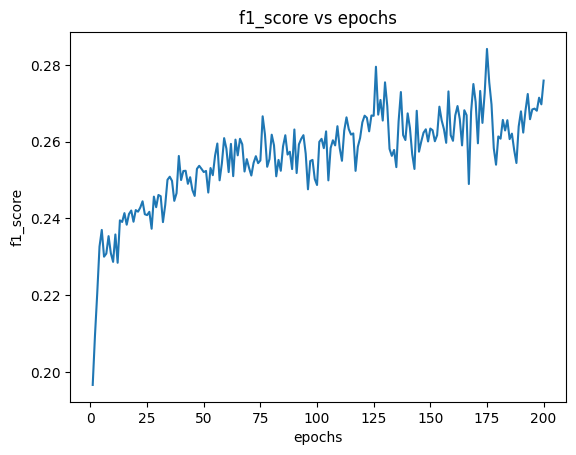

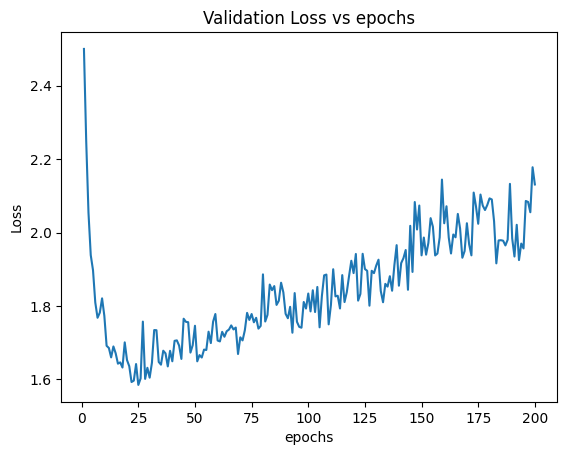

In [43]:
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

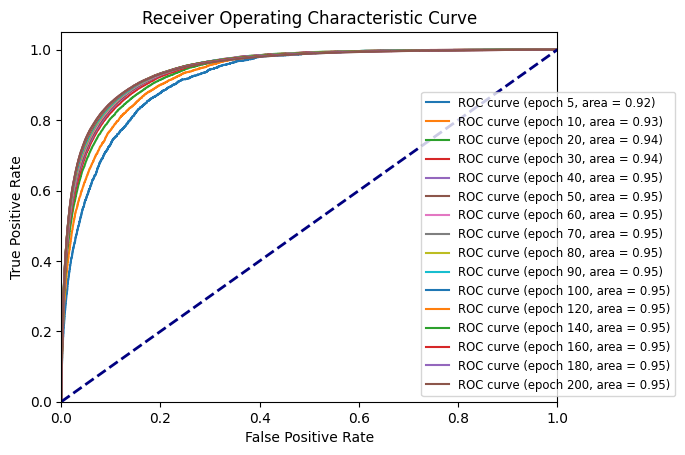

In [42]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [12]:
# display all the ROC plots
for fig in roc_plots:
    fig.show()

<module 'matplotlib.pyplot' from '/home/deependra/project/rfmidc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

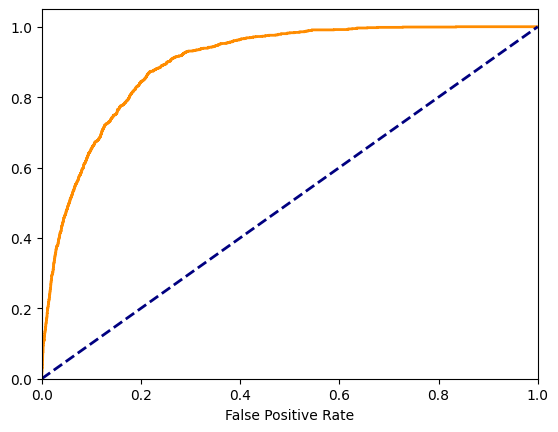

In [9]:
# concatenate the lists of predicted probabilities and true labels for all epochs
train_preds_all = np.concatenate(train_preds_all)
train_labels_all = np.concatenate(train_labels_all)
val_preds_all = np.concatenate(val_preds_all)
val_labels_all = np.concatenate(val_labels_all)

# calculate ROC curve and AUC score for validation set
fpr, tpr, roc_thresholds = roc_curve(val_labels_all.ravel(), val_preds_all.ravel())
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt